# CMPT 459 – Group 8


## How to use this notebook
1. Install dependencies: `pip install pandas numpy matplotlib seaborn scikit-learn`.
2. Data files (`cleaned_data.csv`, `ObesityDataSet_raw_and_data_sinthetic.csv`) are already in the repo.



## Summary
- **Clustering**: Hierarchical , DBSCAN with PCA reduction and grid over eps/min_samples, CLARANS medoid-based search.
- **Outlier detection**: k-NN distance , Gaussian Mixture, Local Outlier Factor.
- **Feature selection**: Mutual Information top-k (default k=8) + scaling; LASSO optional in pipeline.
- **Classification**: k-NN, Logistic Regression, Random Forest. All consume MI-selected features.
- **Hyperparameter tuning**: GridSearchCV for k-NN and Random Forest.


## Challenges
- We had too many columns after one-hot encoding, so we reduced them with PCA and by keeping only the most informative features.
- Some obesity categories were much rarer than others, so instead of deleting unusual rows we checked them with outlier detectors.
- To avoid flaky models, we validated them with cross-validation and tuned k-NN/Random Forest settings using grid search.

In [1]:
import os
from main import (
    load_and_split_data,
    clustering_analysis,
    outlier_detection,
    feature_selection,
    classification,
    hyperparameter_tuning,
)

Data Split:
Total Samples: 2087
Training Samples: 1252 (60%)
Validation Samples: 417 (20%)
Test Samples: 418 (20%)
1. CLUSTERING ANALYSIS
Original features: 31 to PCA components: 15
Variance explained: 86.4%

==== Hierarchical Clustering ====
Evaluating different number of clusters: 


Number of clusters: 3
Silhoutte score: 0.26385828110924026
Calinski-Harabasz score: 145.14641171613076
Davies-Bouldin score: 2.038457103194569


Number of clusters: 5
Silhoutte score: 0.1835778854991973
Calinski-Harabasz score: 148.482465971174
Davies-Bouldin score: 1.8465179172823447


Number of clusters: 7
Silhoutte score: 0.19678835127778485
Calinski-Harabasz score: 144.43601687958454
Davies-Bouldin score: 1.8900756665514085


Number of clusters: 9
Silhoutte score: 0.21841896803579156
Calinski-Harabasz score: 149.1994524044452
Davies-Bouldin score: 1.5343309518940542


Best number of clusters: 3

PCA Visualization:


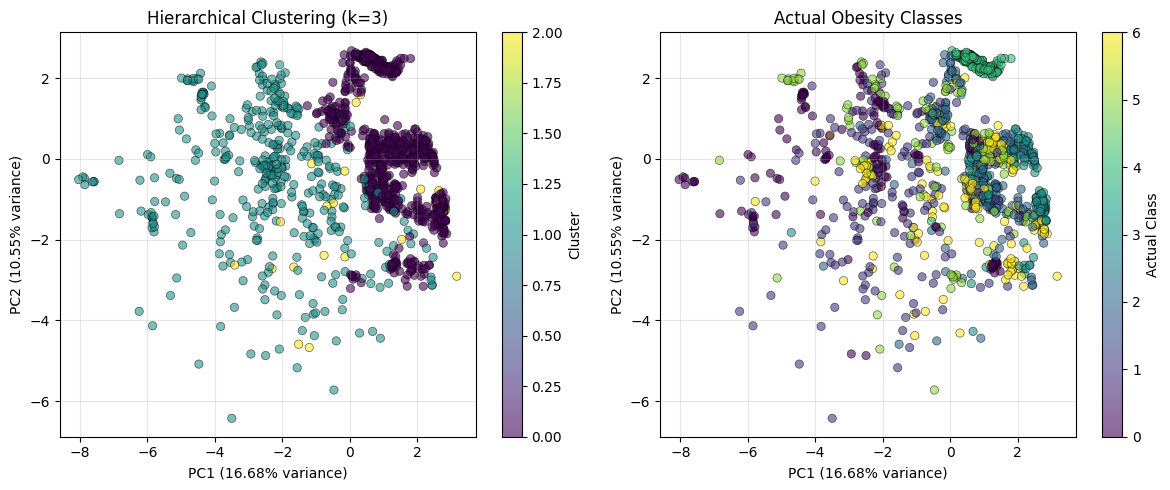


Cluster Characteristics:
Cluster 0 (n=815): Most common class = Obesity_Type_I
Cluster 1 (n=411): Most common class = Normal_Weight
Cluster 2 (n=26): Most common class = Obesity_Type_II

*** Hierarchical Clustering Analysis Discussion ***

 Note: while hierarchical clustering usually produces dendogram, but in here we specificy n_cluster for fair comparison with other clustering algorithms
Hierarchical clustering with Ward linkage fits this obesity dataset well because the points are grouped based on distances in the features and doesn't really need class labels to find structure. From the k values tested, k=3 achieved the highest silhouette score of 0.264 compared to other k values tested. Therefore, the algorithm and the PCA successfully identified 3 clusters that fit the major obesity categories. 

==== CLARANS Clustering ====
Input: 15 PCA components (pre-processed)
Evaluating clusters: [3, 5, 7, 9]

k=3: silhouette=0.135, calinski=105.3, davies_bouldin=2.483
k=5: silhouette=0.176

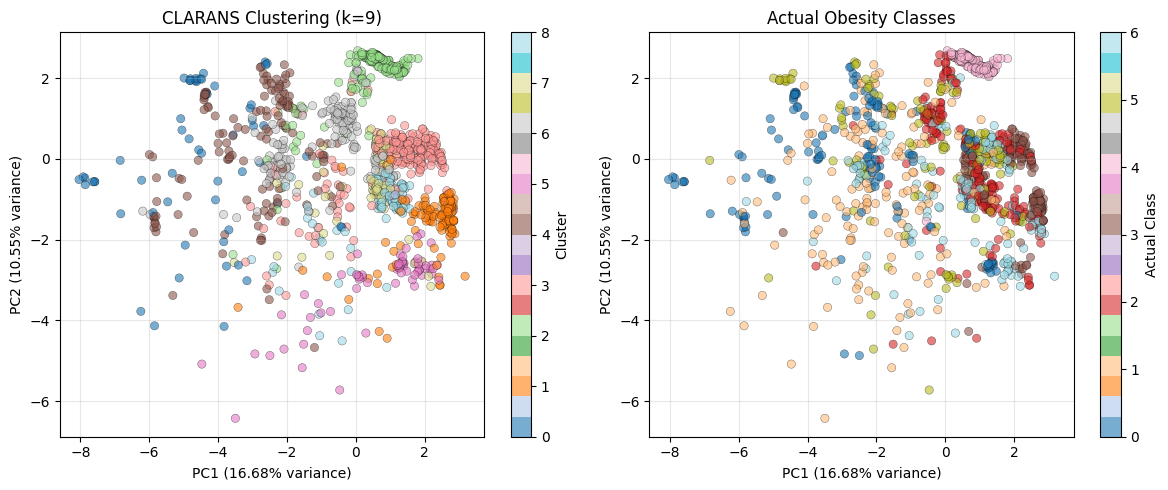


==== DBSCAN Clustering ====
Input: 15 PCA components (pre-processed)


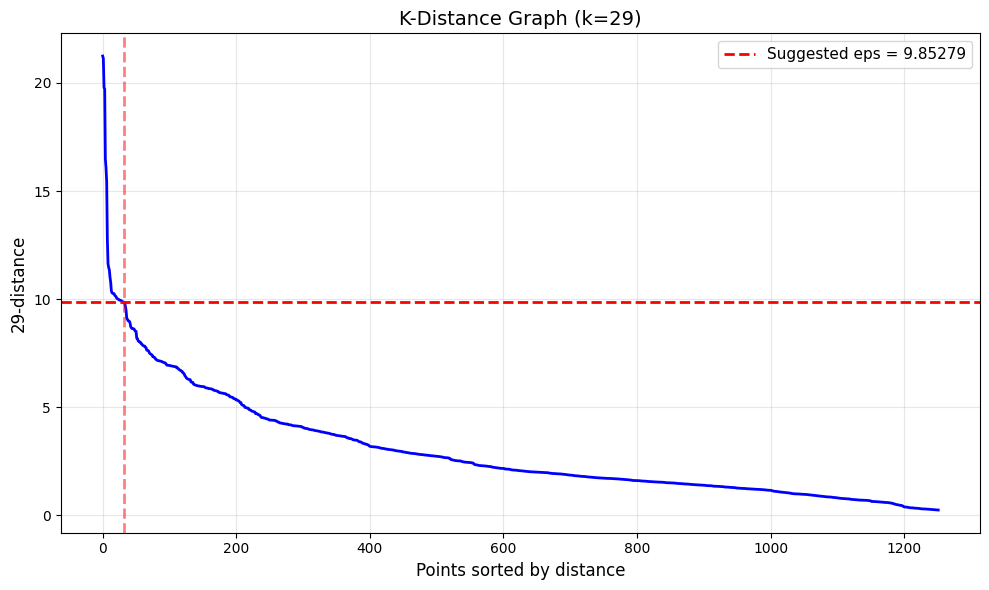

Parameter Selection:
 - d = 15
 - k = 29
 - MinPts = 30
 - epsilon = 9.85279
Results with parameter selection eps: 9.85279, clusters: 1, noise: 8, silhouette: unavailable

Trying different eps values using a multiplier for more meaningful results

eps: 2.95584, clusters: 3, noise: 361, silhouette: 0.29350
eps: 4.92640, clusters: 1, noise: 182, silhouette: unavailable
eps: 7.88223, clusters: 1, noise: 34, silhouette: unavailable

Selected eps=2.95584 based on best silhouette score

DBSCAN Results:
 - eps=2.95584, min_samples=30,clusters: 3, noise: 361 (28.8%)
 - Silhouette Score: 0.29350
 - Calinski-Harabasz Index: 99.53953
 - Davies-Bouldin Index: 1.06331

PCA visualization: 


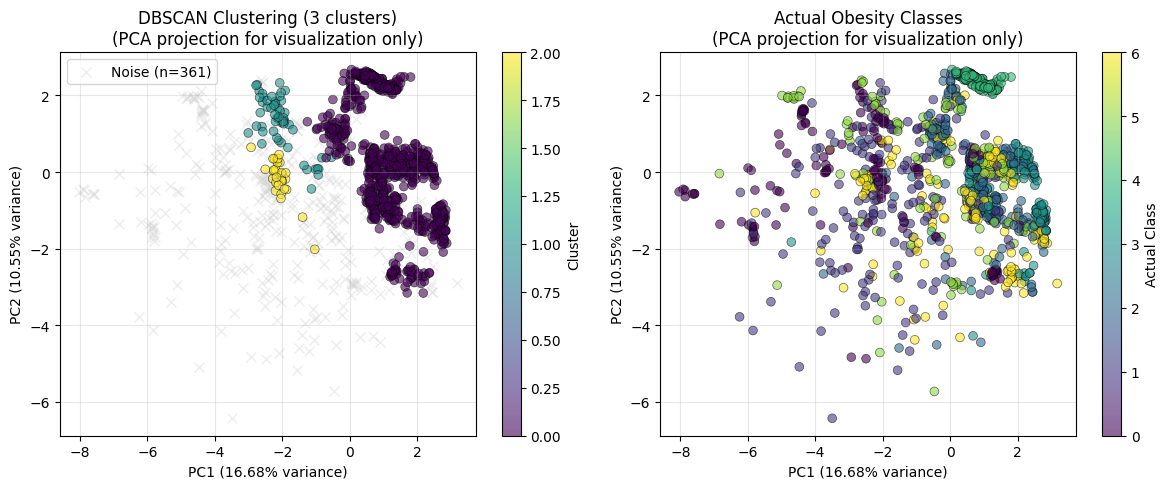


Cluster Composition:
 - Noise (n=361, 28.8
 - Cluster 0 (n=806, 64.4%): Most common = Obesity_Type_I
 - Cluster 1 (n=55, 4.4%): Most common = Insufficient_Weight
 - Cluster 2 (n=30, 2.4%): Most common = Insufficient_Weight

DBSCAN with heurestic parameter selections gave a value of eps as 9.8528 and 1 clusters which does not give us much information. Applied a multipler to attempt to reduce the value of eps to get more meaningful data. This reduction gave us an optimal eps of 2.9558 and 3 with a silhouette score of 0.2935. Overall DBSCAN does not perform well on this dataset due to the large dimension (15) of this dataset.

*** Clustering comparison summary***
Algorithm       k     Silhouette   Calinski-H   Davies-B    
------------------------------------------------------------
Hierarchical    3     0.264        149.2        1.534       
CLARANS         9     0.215        101.4        1.869       
DBSCAN          3     0.293        99.5         1.063        28.8        
------------

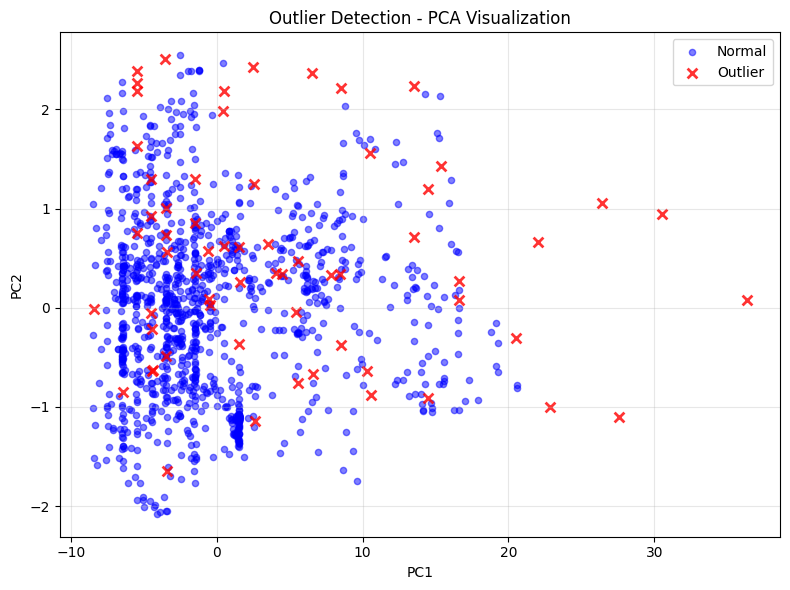


Outlier Distribution by Obesity Class:
  • Insufficient_Weight: 6/159 (3.77%)
  • Normal_Weight: 33/160 (20.62%)
  • Obesity_Type_I: 3/224 (1.34%)
  • Obesity_Type_II: 2/178 (1.12%)
  • Obesity_Type_III: 0/193 (0.00%)
  • Overweight_Level_I: 7/159 (4.40%)
  • Overweight_Level_II: 12/179 (6.70%)

Outlier Analysis:

We going to keep all the data since outliers mostly represent unusual but valid combinations of features (including extreme normal-weight and obese cases).


==== Probabilistic Outlier Detection ====
Using 3 Gaussian components

Outlier Detection Results:
  • Threshold (5th percentile log-likelihood): 48.9908
  • Outliers detected: 63 (5.03%)
  • Normal samples: 1189
  • EM algorithm converged: True

Visualizing outliers


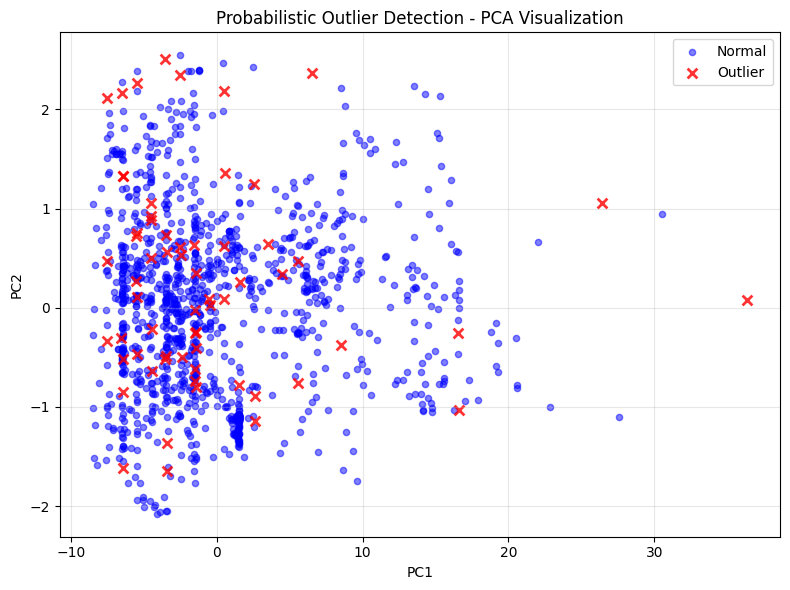


Outlier Distribution by Obesity Class:
  • Insufficient_Weight: 6/159 (3.77%)
  • Normal_Weight: 29/160 (18.12%)
  • Obesity_Type_I: 7/224 (3.12%)
  • Obesity_Type_II: 4/178 (2.25%)
  • Obesity_Type_III: 0/193 (0.00%)
  • Overweight_Level_I: 11/159 (6.92%)
  • Overweight_Level_II: 6/179 (3.35%)

Outlier Analysis:
Probabilistic outliers represent samples with low probability. We decided to keep them as they are unusual but plausible combinations of features. The outliers represent valid edge cases that could provide important insights into rare obesity patterns.


==== LOF Outlier Detection ====
Using n_neighbors=20, contamination=0.05

Outlier Detection Results:
  • Score threshold (approx.): 1.5672
  • Outliers detected: 63 (5.03%)
  • Normal samples: 1189

Visualizing outliers


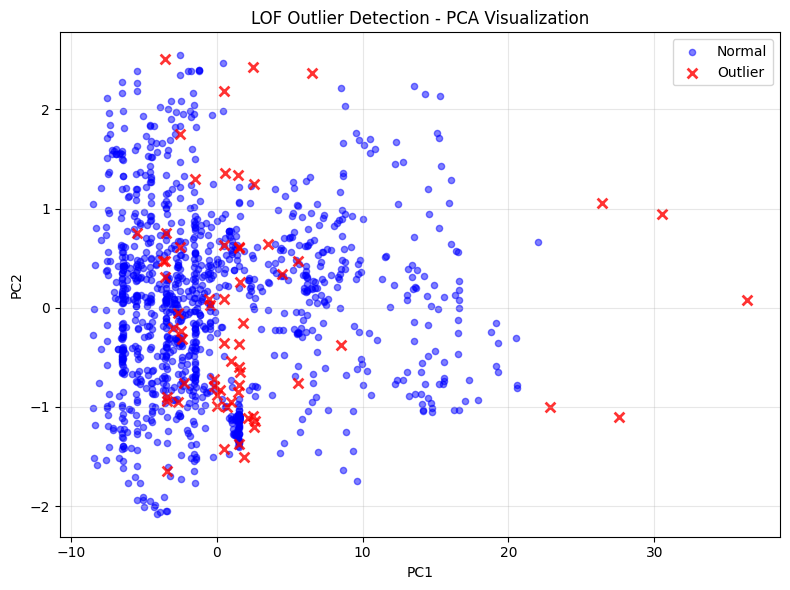


Outlier Distribution by Obesity Class:
  • Insufficient_Weight: 1/159 (0.63%)
  • Normal_Weight: 25/160 (15.62%)
  • Obesity_Type_I: 4/224 (1.79%)
  • Obesity_Type_II: 1/178 (0.56%)
  • Obesity_Type_III: 9/193 (4.66%)
  • Overweight_Level_I: 12/159 (7.55%)
  • Overweight_Level_II: 11/179 (6.15%)

*** Outlier Detection Comparison Summary ***
Method               Outliers     Percentage   Threshold      
------------------------------------------------------------
k-NN Distance        63           5.03         2.0079         
Probabilistic (GMM)  63           5.03         48.9908        
LOF                  63           5.03         1.5672         
------------------------------------------------------------
All three methods detected similar outlier counts (63-63 outliers) which is about 5%, showing consistency across different detection approaches.

Normal weight class shows highest outlier rate (15-21% across methods) showing variability, while Obesity_Type_III shows lowest outlier 

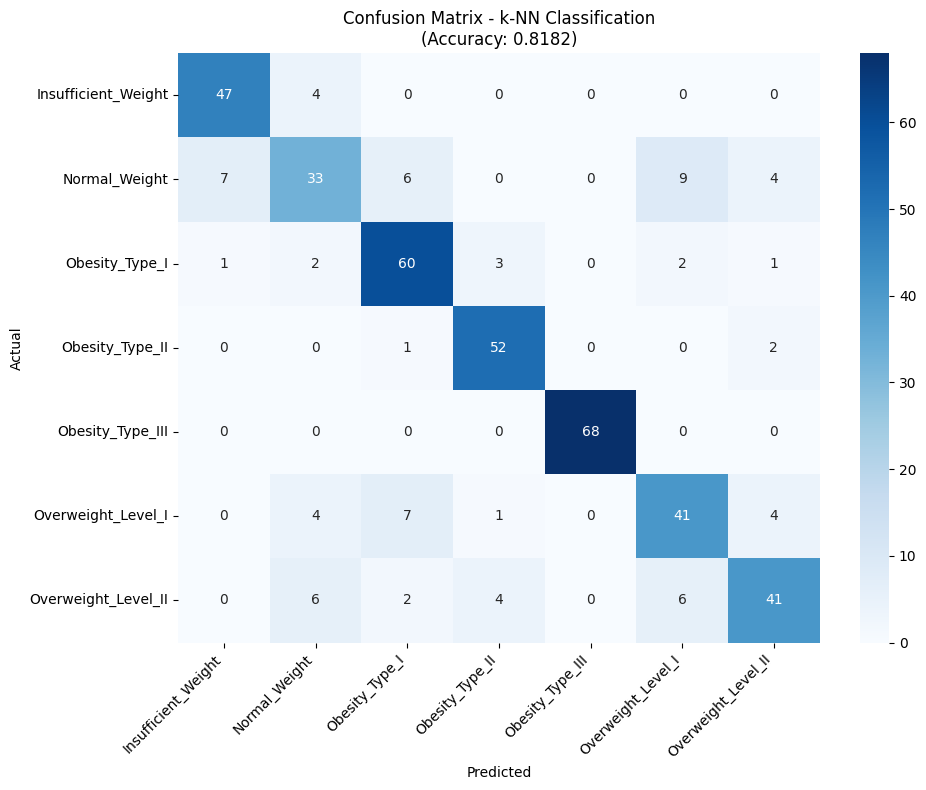

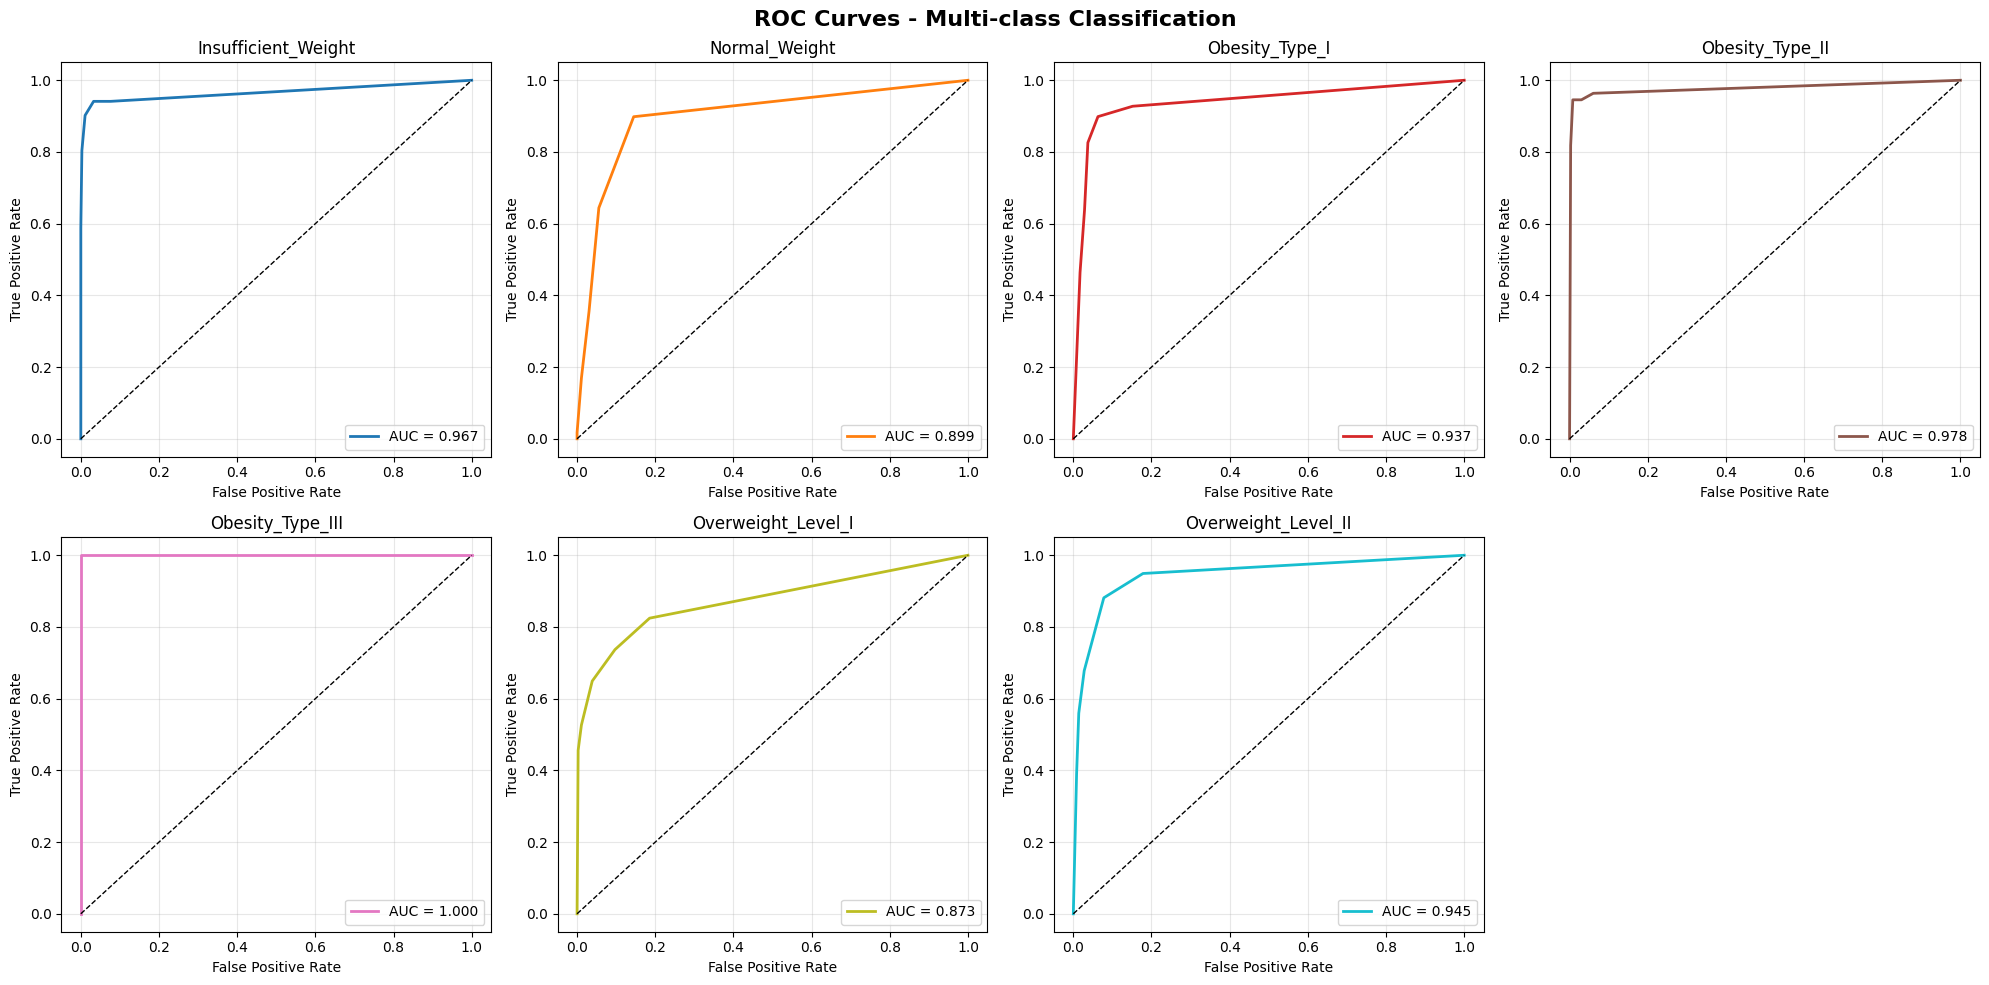


==== Logistic Regression Classification ====

Classification Metrics (Logistic Regression with 21 features):
Accuracy:  0.8612
Precision: 0.8635
Recall:    0.8612
F1-Score:  0.8599

5-Fold Cross-Validation:
Mean: 0.8483 (±0.0054)
Scores: ['0.8406', '0.8446', '0.8480', '0.8560', '0.8520']

Detailed Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.86      0.94      0.90        51
      Normal_Weight       0.88      0.76      0.82        59
     Obesity_Type_I       0.87      0.84      0.85        69
    Obesity_Type_II       0.87      0.96      0.91        55
   Obesity_Type_III       0.99      0.99      0.99        68
 Overweight_Level_I       0.83      0.70      0.76        57
Overweight_Level_II       0.73      0.83      0.78        59

           accuracy                           0.86       418
          macro avg       0.86      0.86      0.86       418
       weighted avg       0.86      0.86      0.86       418



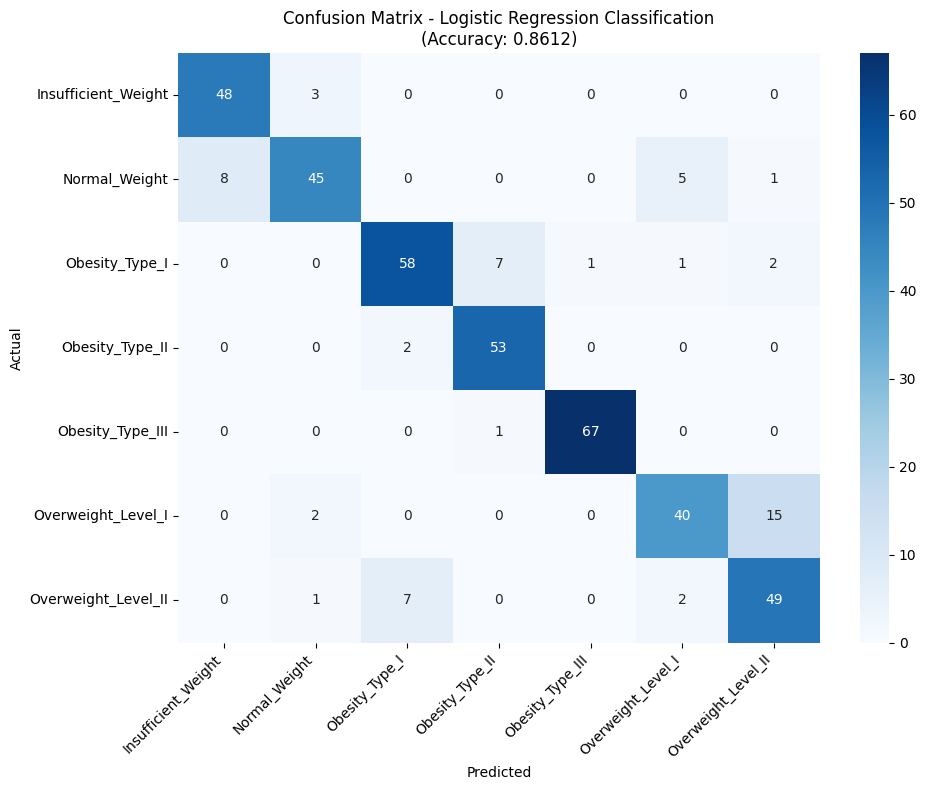

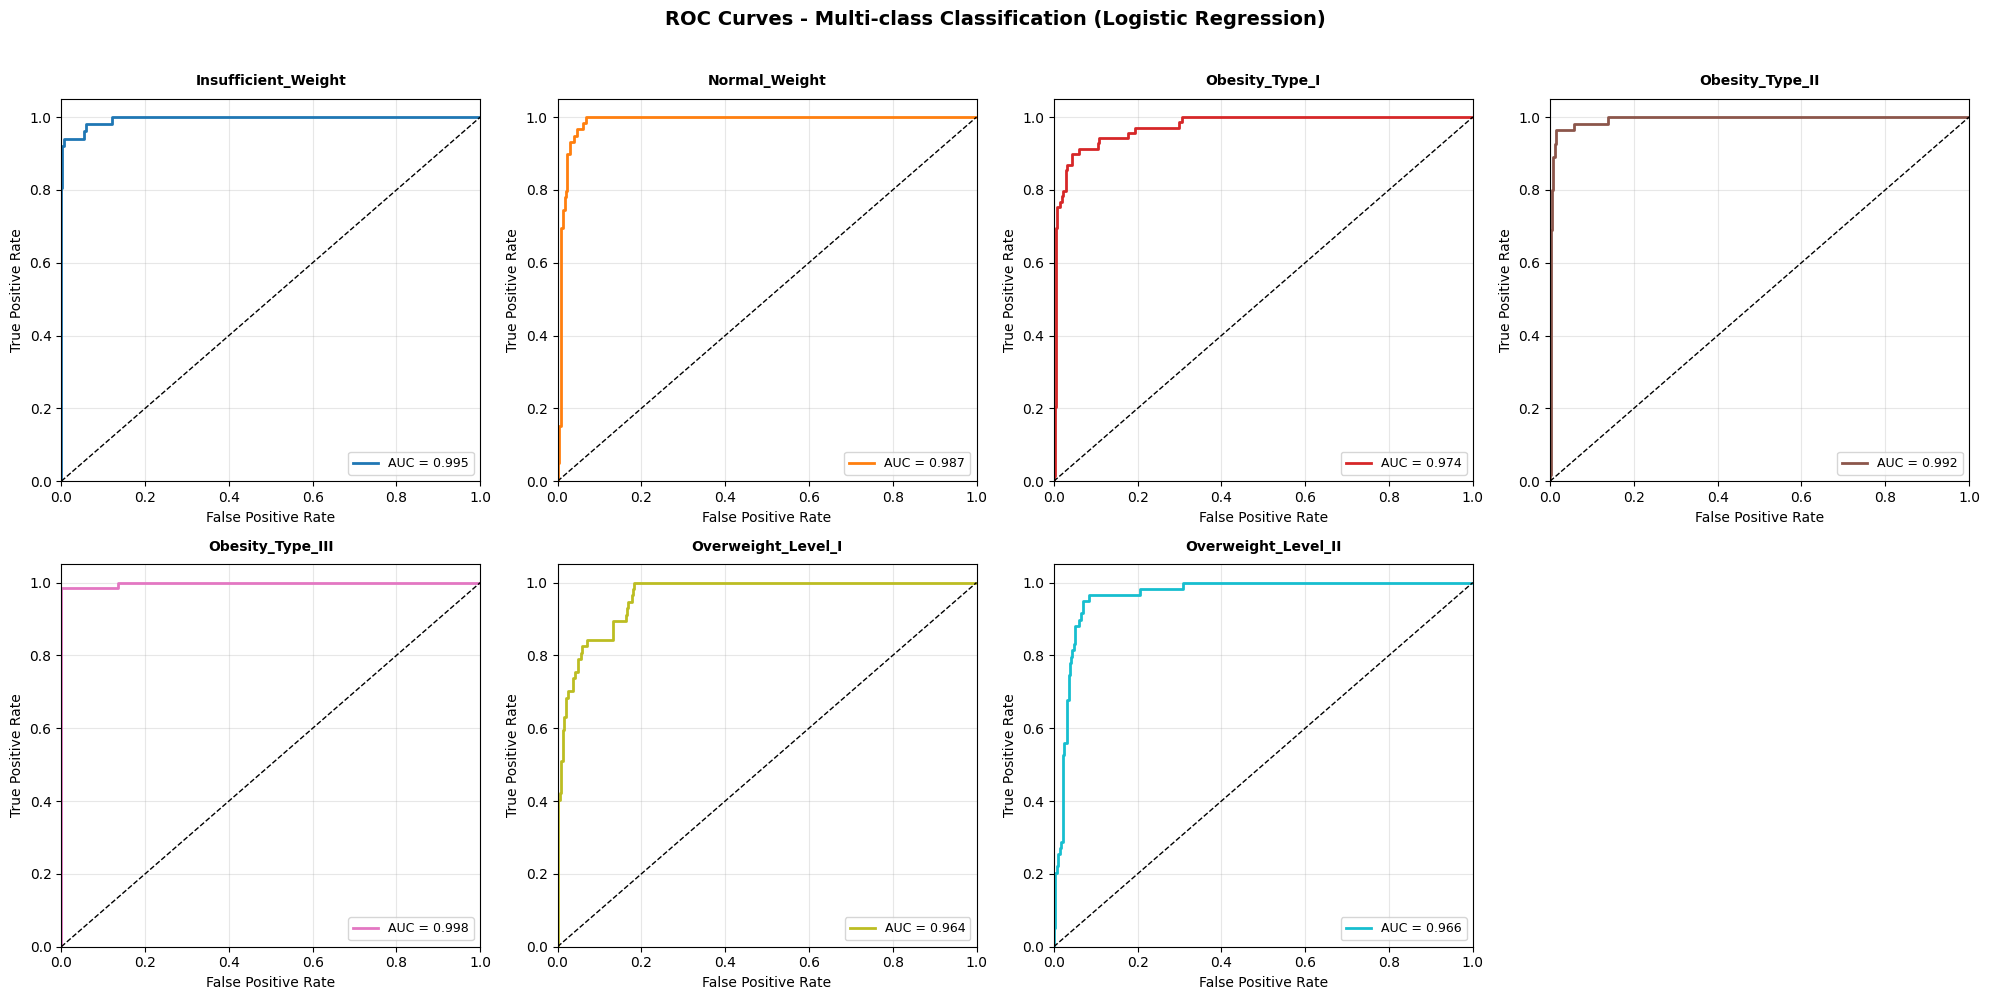


==== Random Forest Classification ====

Classification Metrics (Random Forest with 21 features):
Accuracy:  0.9545
Precision: 0.9559
Recall:    0.9545
F1-Score:  0.9546

5-Fold Cross-Validation:
Mean: 0.9377 (±0.0142)
Scores: ['0.9163', '0.9562', '0.9280', '0.9400', '0.9480']

Detailed Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.98      0.98      0.98        51
      Normal_Weight       0.86      0.97      0.91        59
     Obesity_Type_I       0.97      0.97      0.97        69
    Obesity_Type_II       1.00      1.00      1.00        55
   Obesity_Type_III       1.00      0.99      0.99        68
 Overweight_Level_I       0.92      0.86      0.89        57
Overweight_Level_II       0.95      0.92      0.93        59

           accuracy                           0.95       418
          macro avg       0.96      0.95      0.95       418
       weighted avg       0.96      0.95      0.95       418



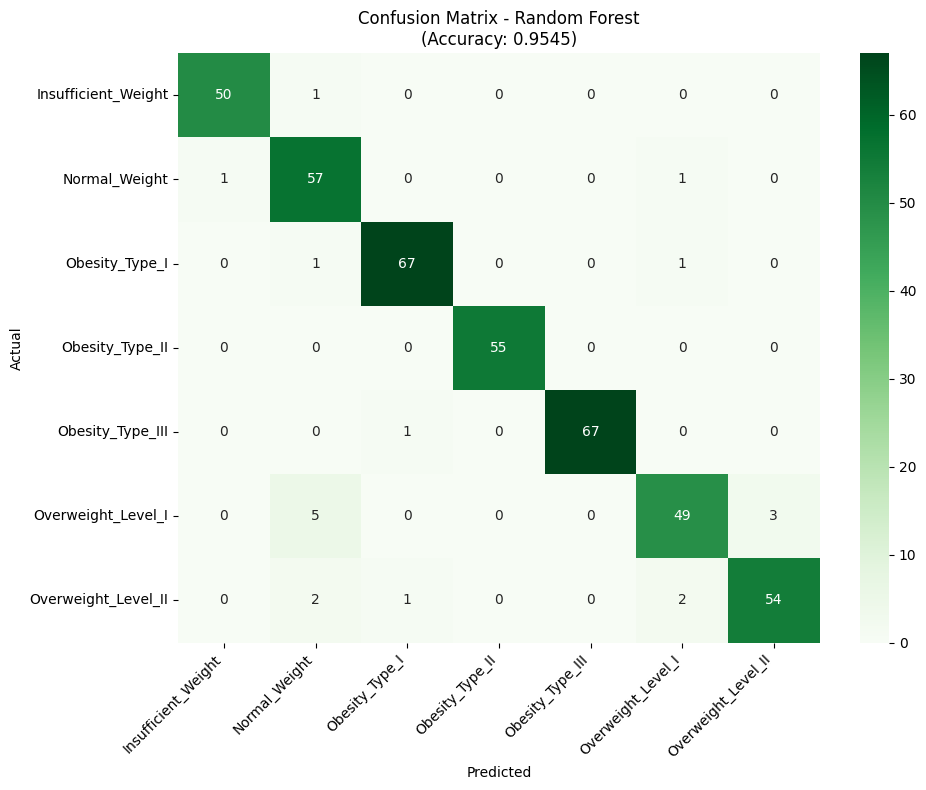

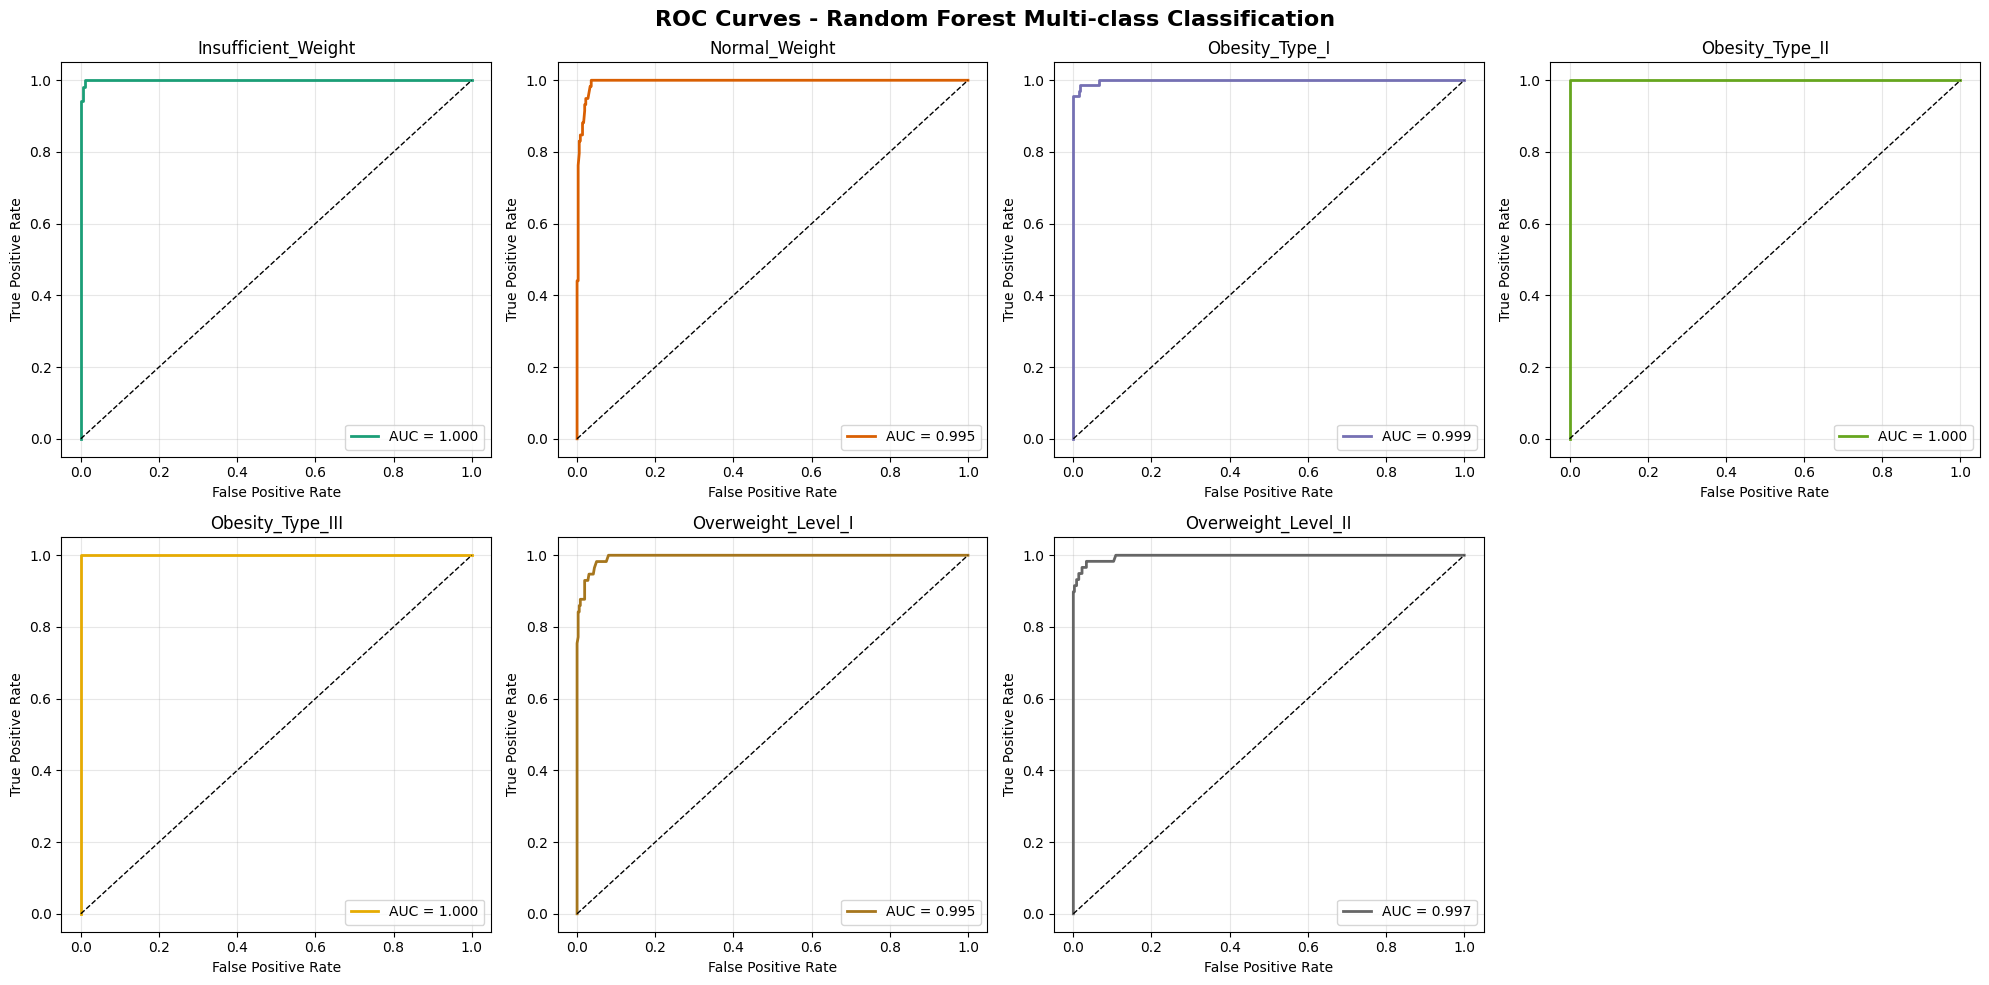


--- Feature Importance (Top 10) ---
                          Feature  Importance
                           Weight    0.314229
                           Height    0.104454
                              Age    0.101920
                             FCVC    0.096101
                    Gender_Female    0.058211
                              FAF    0.058164
                              NCP    0.057883
                              TUE    0.055150
family_history_with_overweight_no    0.035773
                          CALC_no    0.027679

*** CLASSIFICATION COMPARISON SUMMARY ***
Classifier           Accuracy     Precision    Recall       F1-Score     CV Mean     
--------------------------------------------------------------------------------
k-NN                 0.8182       0.8140       0.8182       0.8142       0.7780      
Logistic Regression  0.8612       0.8635       0.8612       0.8599       0.8483      
Random Forest        0.9545       0.9559       0.9545       0.9546       0.

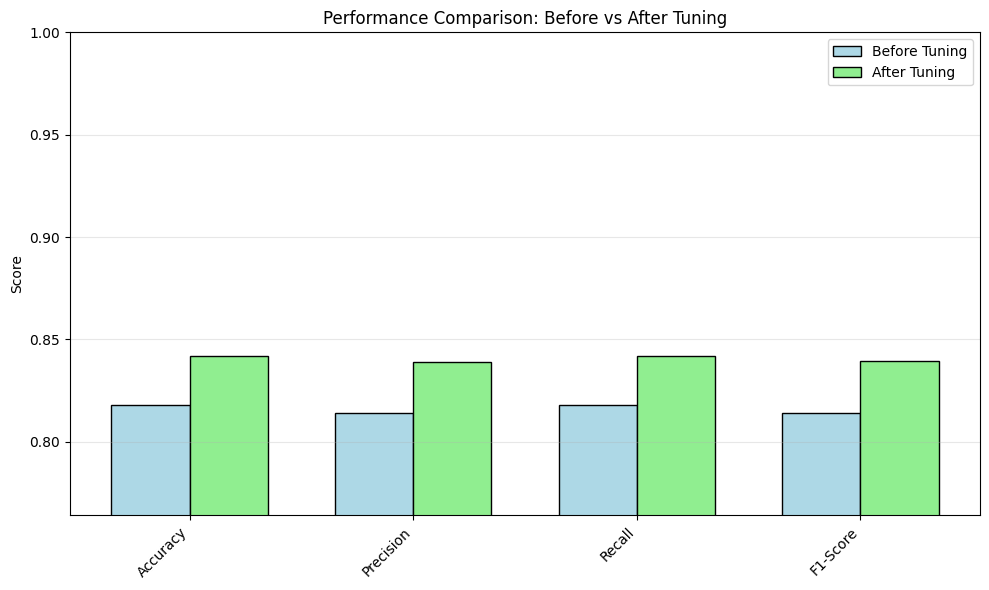


 ==== Hyperparameter Tuning for Random Forest ====
Fitting 3 folds for each of 81 candidates, totalling 243 fits

Tuned Model Performance:
Accuracy:  0.9569
Precision: 0.9580
Recall:    0.9569
F1-Score:  0.9568

Impact of Hyperparameter Tuning
                    Model  Accuracy  Precision   Recall  F1-Score
            Before Tuning  0.954545   0.955855 0.954545  0.954586
After Tuning (GridSearch)  0.956938   0.958043 0.956938  0.956843

Findings:
Accuracy improvement: +0.0024
Best params: {'max_depth': None, 'max_features': None, 'min_samples_split': 2, 'n_estimators': 300}

==== Hyperparameter Tuning for Logistic Regression ====
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Tuned Model Performance:
 - Accuracy: 0.9426
 - Precision: 0.9460
 - Recall: 0.9426
 - F1-Score: 0.9426

Impact of Hyperparameter Tuning
        Model  Accuracy  Precision   Recall  F1-Score
Before Tuning  0.861244   0.863494 0.861244  0.859949
 After Tuning  0.942584   0.946037 0.942584  0.9425

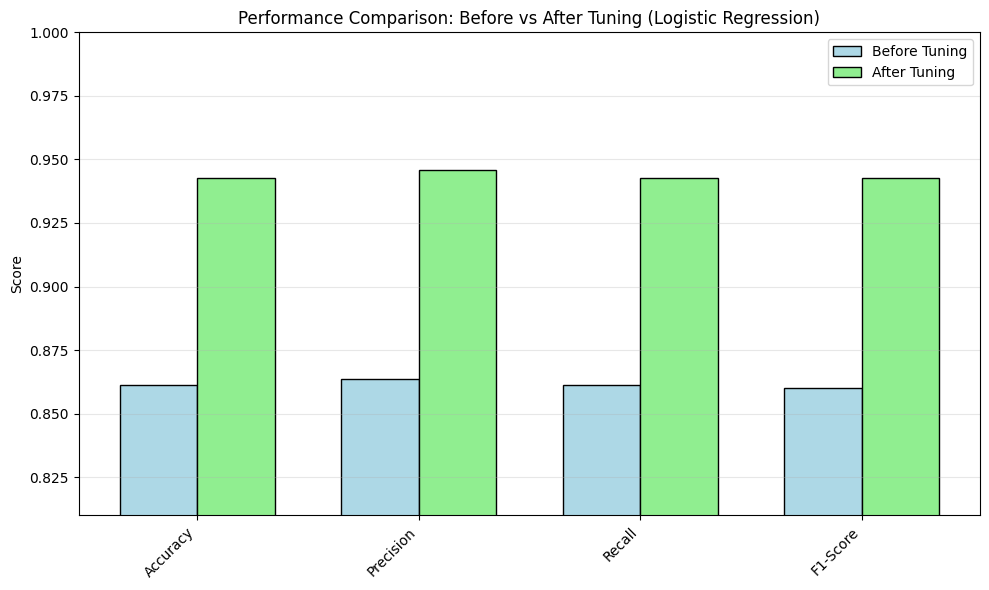


*** HYPERPARAMETER TUNING SUMMARY ***
Classifier           Before       After        Improvement    
------------------------------------------------------------
k-NN                 0.8182       0.8421       +0.0239 (+2.4%)
Random Forest        0.9545       0.9569       +0.0024 (+0.2%)
Logistic Regression  0.8612       0.9426       +0.0813 (+8.1%)
------------------------------------------------------------



{'knn_accuracy': 0.8181818181818182,
 'lr_accuracy': 0.861244019138756,
 'rf_accuracy': 0.9545454545454546,
 'knn_cv_mean': np.float64(0.7779760956175299),
 'lr_auc_avg': np.float64(0.9821509206043793),
 'rf_auc_avg': np.float64(0.9978927341097287),
 'rf_tuned_accuracy': 0.9569377990430622,
 'knn_tuned_accuracy': 0.8421052631578947}

In [2]:
data, train_data, valid_data, test_data = load_and_split_data()

clustering_results = clustering_analysis(train_data)
outlier_results = outlier_detection(train_data)
feature_selection_results = feature_selection(train_data, valid_data, test_data)
classification_results = classification(train_data, valid_data, test_data, feature_selection_results)
tuning_results = hyperparameter_tuning(classification_results)

summary_metrics = {
    'knn_accuracy': classification_results['knn']['accuracy'],
    'lr_accuracy': classification_results['logistic_regression']['accuracy'],
    'rf_accuracy': classification_results['random_forest']['accuracy'],
    'knn_cv_mean': classification_results['knn']['cv_mean'],
    'lr_auc_avg': classification_results['logistic_regression']['roc_auc_avg'],
    'rf_auc_avg': classification_results['random_forest']['roc_auc_avg'],
    'rf_tuned_accuracy': tuning_results['random_forest_tuned']['tuned_accuracy'],
    'knn_tuned_accuracy': tuning_results['knn_tuned']['tuned_accuracy'],
}
summary_metrics
